In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
failure_data=pd.read_csv("failure_data_discretized.csv")
failure_data.head()

,ANNUAL_SALES,IN_DEFAULT,LGD_EFFECTIVE,BALANCE,LEVERAGE_BUYOUT_DEAL,RETURN_ON_ASSETS,DEBT_SRV_CVR_RATIO,CASH_INT_CVR_RATIO,DEBT_DEBT_EQ_RATIO,CASH_FLOW_OP_LIAB,EBITDA_VOLATILITY,NET_WORTH_CPI,NEGATIVE_NPAT_FLAG,MARKET_POSITION,LONG_RUN_AVERAGE_PD
0,s1_below_1370087168,0,s3_43_up,s3_18790_80297,1,s1_below_0,s3_0_4,s2_0_100,s6_0_0,s2_0_0,s2_0_0,s2_6_7,1,s4_0_0,s08_0_0
1,s2_1370087168_n2147483648,0,s3_43_up,s4_80297_270937,1,s2_0_0,s2_0_0,s2_0_100,s3_0_0,s4_0_1,s2_0_0,s4_8_8,0,s7_2_3,s01_below_0
2,s1_below_1370087168,0,s3_43_up,s7_2691666_up,0,s2_0_0,s2_0_0,s2_0_100,s7_0_up,s2_0_0,s2_0_0,s1_below_6,0,s4_0_0,s09_0_0
3,s1_below_1370087168,0,s1_below_17,s1_below_4209,0,s2_0_0,s2_0_0,s2_0_100,s7_0_up,s3_0_0,s3_0_1,s1_below_6,0,s9_4_up,s07_0_0
4,s1_below_1370087168,0,s3_43_up,s3_18790_80297,0,s2_0_0,s2_0_0,s2_0_100,s7_0_up,s3_0_0,s3_0_1,s1_below_6,0,s9_4_up,s07_0_0


In [3]:
from sklearn.model_selection import train_test_split
target='LONG_RUN_AVERAGE_PD'
X_train, X_test, _, _ = train_test_split(failure_data, failure_data[target], test_size=0.3, random_state=42)

In [4]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator,BayesianEstimator, PC
from pgmpy.estimators import BicScore, BDeuScore, K2Score

#построение структуры(направленный ациклический граф)
es=HillClimbSearch(X_train, scoring_method=BicScore(X_train))
#es=PC(data=X_train)
best_model=es.estimate()

#настройка параметров
model=BayesianModel(best_model.edges())
model.fit(data=X_train, estimator=BayesianEstimator,equivalent_sample_size=10)

  0%|          | 29/1000000 [00:05<52:12:26,  5.32it/s]


In [5]:
print(model.nodes())

['ANNUAL_SALES', 'LEVERAGE_BUYOUT_DEAL', 'BALANCE', 'MARKET_POSITION', 'IN_DEFAULT', 'RETURN_ON_ASSETS', 'LGD_EFFECTIVE', 'EBITDA_VOLATILITY', 'NET_WORTH_CPI', 'NEGATIVE_NPAT_FLAG', 'DEBT_DEBT_EQ_RATIO', 'DEBT_SRV_CVR_RATIO', 'CASH_INT_CVR_RATIO', 'CASH_FLOW_OP_LIAB', 'LONG_RUN_AVERAGE_PD']


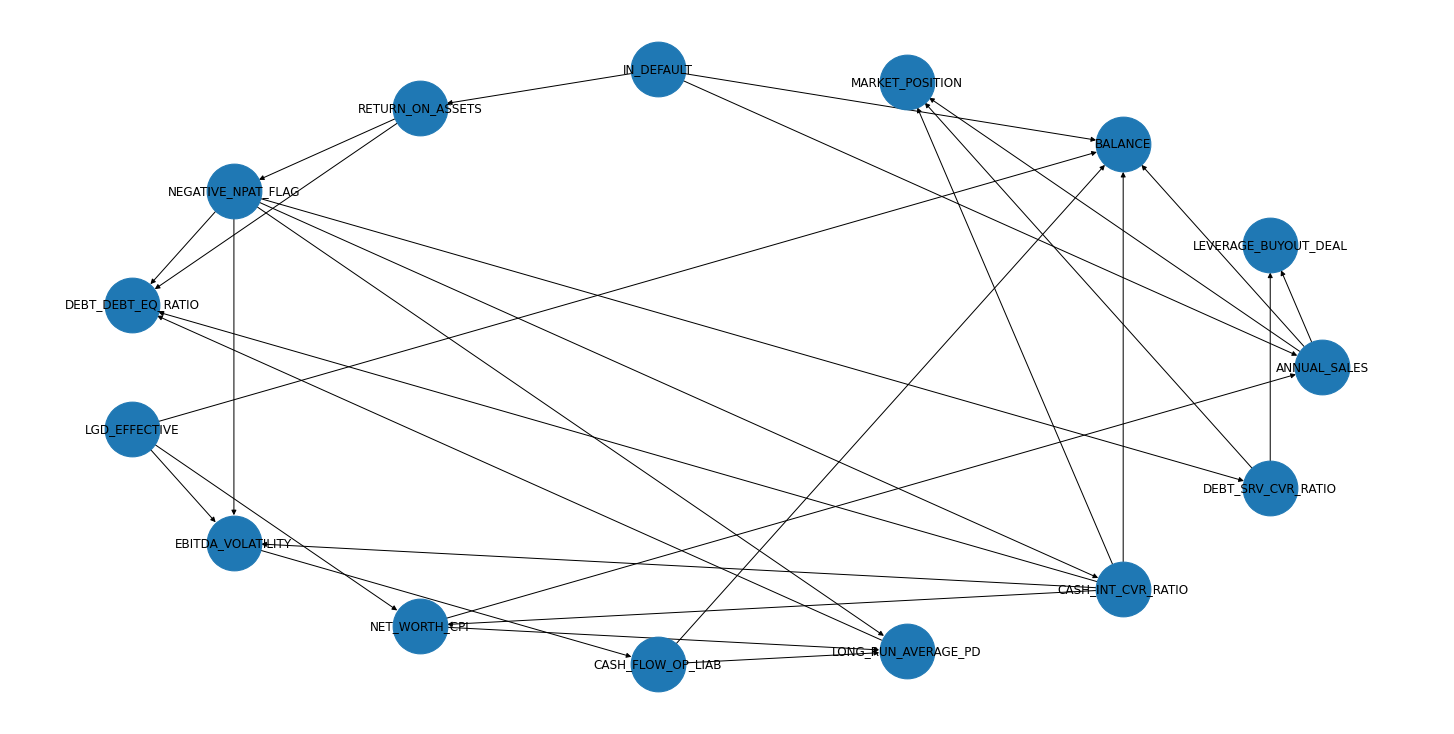

In [6]:
import networkx as nx
import matplotlib.pyplot as plt 

G = nx.MultiDiGraph()
G.add_edges_from(model.edges())

plt.figure(figsize=(20,10))
#nx.draw_networkx(G,node_size=3000)
nx.draw_circular(G,node_size=3000, with_labels=True)

In [7]:
y_test=X_test[target]
y_pred=model.predict(X_test.drop(columns=[target]))

100%|██████████| 111/111 [01:03<00:00,  1.75it/s]


In [8]:
from sklearn.metrics import confusion_matrix,accuracy_score
print(confusion_matrix(y_test,y_pred))

[[ 4  1  3  0  0  0  0  0  0  0]
 [ 4  8  1  1  0  0  0  0  0  0]
 [ 3  2  1  1  1  0  2  0  1  0]
 [ 0  1  0  3  2  2  1  0  0  0]
 [ 0  1  0  0  5  1  2  0  0  0]
 [ 0  2  1  0  3  6  2  0  0  0]
 [ 0  0  1  0  0  2  7  4  3  0]
 [ 0  0  0  0  0  1  4  5  3  0]
 [ 0  0  0  0  0  0  0  3  9  0]
 [ 0  0  0  0  0  0  0  0  0 12]]


In [9]:
print(accuracy_score(y_test,y_pred))

0.5042016806722689
